# Multi-Task Pain Classification Model

This notebook implements a neural network for multi-task pain classification, handling both binary and ordinal pain indicators based on biomechanical measurements.

## Setup and Data Preparation

The following cell:
1. Imports required libraries
2. Loads and preprocesses the pain anamnesis data
3. Prepares both binary and ordinal targets

### Data Structure:
- **Input Features** (7 biomechanical measurements):
  - Left/Right movement deviation averages
  - Left/Right resting deviation averages
  - Left/Right step averages
  - Shoe size
- **Binary Targets**: Pain presence (0/1) for various body regions
- **Ordinal Targets**: Pain intensity levels (0-5) for specific conditions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt  # for potential data visualization

# Cell 2: Data Loading and Preprocessing with Validation Split
# Load the Excel file (make sure you have openpyxl installed: pip install openpyxl)
data = pd.read_excel("colored_columns_output_filtered.xlsx")  # Replace with your file path

# Define the 7 input columns.
input_cols = [
    "SchiefstandBewegungMmDurchschnitt_links",
    "SchiefstandBewegungMmDurchschnitt_rechts",
    "SchiefstandRuheMmDurchschnitt_links",
    "SchiefstandRuheMmDurchschnitt_rechts",
    "AuftrittDurchschnitt_links",
    "AuftrittDurchschnitt_rechts",
    "Schuhgröße"
]

# Define the target columns.
binary_target_cols = [
    "Schmerz_Vorfuß_Links", "Schmerz_Vorfuß_Rechts", 
    "Schmerz_Mittelfuß_Links", "Schmerz_Mittelfuß_Rechts",
    "Schmerz_Ferse_Links", "Schmerz_Ferse_Rechts",
    "Schmerz_Handgelenk_links", "Schmerz_Handgelenk_rechts",	
    "Schmerz_Ellenbogen_links", "Schmerz_Ellenbogen_rechts",	
    "Schmerz_Finger_links",	"Schmerz_Finger_rechts",	
    "Schmerz_Oberarm_links", "Schmerz_Oberarm_rechts",	
    "Schmerz_Daumen_links",	"Schmerz_Daumen_rechts",	
    "Schmerz_Unterarm_links", "Schmerz_Unterarm_rechts"
]

# Assume that any "Schmerz_*" column that is not in binary_target_cols is ordinal.
all_schmerz_cols = [col for col in data.columns if col.startswith("Schmerz_")]
ordinal_target_cols = [col for col in all_schmerz_cols if col not in binary_target_cols]

# Clean data.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=ordinal_target_cols, inplace=True)

# Convert binary targets to 0/1.
for col in binary_target_cols:
    data[col] = data[col].map({True: 1, 'TRUE': 1, 'True': 1,
                               False: 0, 'FALSE': 0, 'False': 0})

# Ensure ordinal targets are integers.
for col in ordinal_target_cols:
    data[col] = data[col].astype(int)

# Extract features and targets.
X = data[input_cols].values.astype(np.float32)
y_binary = data[binary_target_cols].values.astype(np.float32)
y_ordinal = data[ordinal_target_cols].values.astype(np.int64)  # class labels (e.g., 0–5)

# Split data into train (70%), validation (15%), and test (15%)
X_train_val, X_test, yb_train_val, yb_test, yo_train_val, yo_test = train_test_split(
    X, y_binary, y_ordinal, test_size=0.15, random_state=42
)
X_train, X_val, yb_train, yb_val, yo_train, yo_val = train_test_split(
    X_train_val, yb_train_val, yo_train_val, test_size=0.1765, random_state=42
)  # 0.1765 * 0.85 ≈ 15%

# Scale the input features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# (Optional) Visualize feature distributions to check for outliers, etc.
# plt.hist(X_train[:, 0], bins=50)
# plt.title("Distribution of Feature 1")
# plt.show()

## Custom Dataset Implementation

The `PainDataset` class manages data for multi-task learning:

1. **Features**:
   - Converts numpy arrays to PyTorch tensors
   - Handles standardized input features
   - Manages batch processing

2. **Labels**:
   - Binary targets: Pain presence indicators (0/1)
   - Ordinal targets: Pain intensity levels (0-5)
   - Maintains separate target types for multi-task learning

3. **Data Loading**:
   - Implements PyTorch Dataset interface
   - Enables efficient batch processing
   - Returns feature-binary-ordinal triplets

In [2]:
class PainDataset(Dataset):
    def __init__(self, X, y_binary, y_ordinal):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_binary = torch.tensor(y_binary, dtype=torch.float32)
        self.y_ordinal = torch.tensor(y_ordinal, dtype=torch.long)  # shape: (n_samples, num_ordinal)
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y_binary[idx], self.y_ordinal[idx]

# Create dataset instances.
train_dataset = PainDataset(X_train, yb_train, yo_train)
val_dataset   = PainDataset(X_val, yb_val, yo_val)
test_dataset  = PainDataset(X_test, yb_test, yo_test)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Multi-Task Neural Network Architecture

The `MultiTaskModel` implements a shared-trunk architecture with task-specific heads:

1. **Shared Layers**:
   - Three fully connected layers (64 → 32 → 32 neurons)
   - Batch normalization for training stability
   - Dropout for regularization
   - LeakyReLU activation functions

2. **Task-Specific Heads**:
   - Binary Classification Head:
     - Direct logits output for binary targets
   - Ordinal Classification Heads:
     - Consistent Ordinal Ranking (CORAL) implementation
     - Separate head for each ordinal target
     - Threshold-based ordinal prediction

3. **Design Features**:
   - Parameter sharing for efficient learning
   - Task-specific adaptation layers
   - CORAL architecture for ordinal prediction

In [3]:
class MultiTaskModel(nn.Module):
    def __init__(self, input_dim, num_binary, num_ordinal, num_ordinal_classes=6):
        super(MultiTaskModel, self).__init__()
        # Shared layers with an extra hidden layer and LeakyReLU activation.
        self.shared_fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.shared_fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.shared_fc3 = nn.Linear(32, 32)  # Additional hidden layer
        self.bn3 = nn.BatchNorm1d(32)
        
        # Binary head: outputs logits for each binary target.
        self.binary_out = nn.Linear(32, num_binary)
        
        # Ordinal heads using CORAL.
        self.num_thresholds = num_ordinal_classes - 1
        self.ordinal_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(32, 16),
                nn.LeakyReLU(),
                nn.Dropout(0.1),
                nn.Linear(16, self.num_thresholds)
            ) for _ in range(num_ordinal)
        ])
        
    def forward(self, x):
        # Shared trunk with LeakyReLU activations.
        x = F.leaky_relu(self.shared_fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.shared_fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.shared_fc3(x))
        x = self.bn3(x)
        
        # Binary outputs.
        binary_logits = self.binary_out(x)
        
        # Ordinal outputs: one per ordinal target.
        ordinal_logits = [head(x) for head in self.ordinal_heads]
        return binary_logits, ordinal_logits

input_dim = 7  # number of input features
num_binary = len(binary_target_cols)
num_ordinal = len(ordinal_target_cols)
num_ordinal_classes = 6  # e.g., pain levels 0-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(input_dim, num_binary, num_ordinal, num_ordinal_classes).to(device)

## Training Configuration

Implementation of multi-task learning components:

1. **Loss Functions**:
   - Binary Cross-Entropy for binary targets
   - CORAL loss for ordinal targets
   - Weighted combination of task losses

2. **Optimization**:
   - AdamW optimizer with learning rate 0.001
   - ReduceLROnPlateau scheduler
   - Gradient clipping for stability

3. **Metrics**:
   - Binary accuracy for classification tasks
   - Mean Absolute Error (MAE) for ordinal predictions
   - Combined validation metrics for model selection

In [13]:
# Define the loss for binary targets.
criterion_binary = nn.BCEWithLogitsLoss()

# Custom CORAL loss for ordinal targets.
def coral_loss(logits, labels):
    """
    logits: tensor of shape (batch_size, K-1)
    labels: tensor of shape (batch_size,), with integer class labels in {0,1,...,K-1}
    """
    batch_size, num_thresholds = logits.size()
    thresholds = torch.arange(num_thresholds, device=labels.device).unsqueeze(0).expand(batch_size, -1)
    target = (labels.unsqueeze(1) > thresholds).float()
    loss = F.binary_cross_entropy_with_logits(logits, target)
    return loss

# Loss weights.
loss_weight_binary = 1.0
loss_weight_ordinal = 1.0

# Use AdamW optimizer and a ReduceLROnPlateau scheduler.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=5, verbose=True)

num_epochs = 50

# Define metric functions.
def binary_accuracy(preds, targets):
    pred_labels = (torch.sigmoid(preds) > 0.5).float()
    correct = (pred_labels == targets).float()
    return correct.mean().item()

def ordinal_mae(preds, targets):
    # Mean absolute error for ordinal predictions.
    mae = torch.abs(preds - targets.float()).mean().item()
    return mae

/opt/anaconda3/envs/ap/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Model Training Process

The training loop implements:

1. **Training Phase**:
   - Multi-task forward pass
   - Combined loss computation
   - Gradient updates with clipping
   - Metric tracking for both tasks

2. **Validation Phase**:
   - Model evaluation on validation set
   - Separate metrics for each task
   - Learning rate adjustment
   - Model checkpointing

3. **Monitoring**:
   - Loss tracking for both tasks
   - Accuracy metrics for binary predictions
   - MAE for ordinal predictions
   - Early stopping based on validation loss

In [14]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_binary_acc = 0.0
    total_train_ordinal_mae = 0.0
    num_train_samples = 0
    
    for X_batch, yb_batch, yo_batch in train_loader:
        X_batch = X_batch.to(device)
        yb_batch = yb_batch.to(device)
        yo_batch = yo_batch.to(device)
        
        optimizer.zero_grad()
        binary_logits, ordinal_logits_list = model(X_batch)
        
        # Compute binary loss.
        loss_binary = criterion_binary(binary_logits, yb_batch)
        
        # Compute ordinal loss and also prepare predictions (using CORAL threshold method).
        loss_ordinal = 0.0
        ordinal_preds = []
        for i, ordinal_logits in enumerate(ordinal_logits_list):
            loss_ordinal += coral_loss(ordinal_logits, yo_batch[:, i])
            prob_thresholds = torch.sigmoid(ordinal_logits)
            # Predicted class = number of thresholds passed.
            pred_class = (prob_thresholds > 0.5).sum(dim=1)
            ordinal_preds.append(pred_class)
        
        # Total loss.
        loss = loss_weight_binary * loss_binary + loss_weight_ordinal * loss_ordinal
        loss.backward()
        
        # Apply gradient clipping.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        batch_size = X_batch.size(0)
        total_train_loss += loss.item() * batch_size
        total_train_binary_acc += binary_accuracy(binary_logits, yb_batch) * batch_size
        # Average ordinal MAE across all ordinal tasks.
        batch_ordinal_mae = sum([ordinal_mae(pred, yo_batch[:, i].float()) 
                                 for i, pred in enumerate(ordinal_preds)]) / len(ordinal_preds)
        total_train_ordinal_mae += batch_ordinal_mae * batch_size
        num_train_samples += batch_size
    
    avg_train_loss = total_train_loss / num_train_samples
    avg_train_binary_acc = total_train_binary_acc / num_train_samples
    avg_train_ordinal_mae = total_train_ordinal_mae / num_train_samples
    
    # Validation evaluation.
    model.eval()
    total_val_loss = 0.0
    total_val_binary_acc = 0.0
    total_val_ordinal_mae = 0.0
    num_val_samples = 0
    with torch.no_grad():
        for X_batch, yb_batch, yo_batch in val_loader:
            X_batch = X_batch.to(device)
            yb_batch = yb_batch.to(device)
            yo_batch = yo_batch.to(device)
            
            binary_logits, ordinal_logits_list = model(X_batch)
            loss_binary = criterion_binary(binary_logits, yb_batch)
            loss_ordinal = 0.0
            ordinal_preds = []
            for i, ordinal_logits in enumerate(ordinal_logits_list):
                loss_ordinal += coral_loss(ordinal_logits, yo_batch[:, i])
                prob_thresholds = torch.sigmoid(ordinal_logits)
                pred_class = (prob_thresholds > 0.5).sum(dim=1)
                ordinal_preds.append(pred_class)
            loss = loss_weight_binary * loss_binary + loss_weight_ordinal * loss_ordinal
            
            batch_size = X_batch.size(0)
            total_val_loss += loss.item() * batch_size
            total_val_binary_acc += binary_accuracy(binary_logits, yb_batch) * batch_size
            batch_ordinal_mae = sum([ordinal_mae(pred, yo_batch[:, i].float()) 
                                     for i, pred in enumerate(ordinal_preds)]) / len(ordinal_preds)
            total_val_ordinal_mae += batch_ordinal_mae * batch_size
            num_val_samples += batch_size
    
    avg_val_loss = total_val_loss / num_val_samples
    avg_val_binary_acc = total_val_binary_acc / num_val_samples
    avg_val_ordinal_mae = total_val_ordinal_mae / num_val_samples
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Binary Train Acc: {avg_train_binary_acc:.4f} | Ordinal Train MAE: {avg_train_ordinal_mae:.4f}")
    print(f"Binary Val Acc: {avg_val_binary_acc:.4f} | Ordinal Val MAE: {avg_val_ordinal_mae:.4f}")
    
    scheduler.step(avg_val_loss)
    
    # Save the model if validation loss improved.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        print("Validation loss improved, saving model.")

Epoch 1/50 | Train Loss: 10.1774 | Val Loss: 10.3671
Binary Train Acc: 0.7870 | Ordinal Train MAE: 1.3896
Binary Val Acc: 0.8004 | Ordinal Val MAE: 1.4087
Validation loss improved, saving model.
Epoch 2/50 | Train Loss: 10.1911 | Val Loss: 10.3458
Binary Train Acc: 0.7865 | Ordinal Train MAE: 1.3844
Binary Val Acc: 0.8009 | Ordinal Val MAE: 1.3970
Validation loss improved, saving model.
Epoch 3/50 | Train Loss: 10.1605 | Val Loss: 10.3664
Binary Train Acc: 0.7851 | Ordinal Train MAE: 1.3812
Binary Val Acc: 0.8015 | Ordinal Val MAE: 1.4028
Epoch 4/50 | Train Loss: 10.1717 | Val Loss: 10.3647
Binary Train Acc: 0.7854 | Ordinal Train MAE: 1.3907
Binary Val Acc: 0.8009 | Ordinal Val MAE: 1.3992
Epoch 5/50 | Train Loss: 10.1613 | Val Loss: 10.3836
Binary Train Acc: 0.7855 | Ordinal Train MAE: 1.3892
Binary Val Acc: 0.8006 | Ordinal Val MAE: 1.4032
Epoch 6/50 | Train Loss: 10.1439 | Val Loss: 10.3694
Binary Train Acc: 0.7854 | Ordinal Train MAE: 1.3827
Binary Val Acc: 0.8002 | Ordinal Val MA

## Model Inference and Evaluation

Demonstrates the model's prediction capabilities:

1. **Inference Process**:
   - Loads best model state
   - Generates predictions for both tasks
   - Applies appropriate thresholding

2. **Output Format**:
   - Binary predictions: Probability scores (0-1)
   - Ordinal predictions: Integer class labels
   - Separate handling of task outputs

3. **Interpretation**:
   - Probability thresholding for binary decisions
   - CORAL threshold counting for ordinal predictions
   - Example predictions visualization

In [15]:
model.eval()
with torch.no_grad():
    # For demonstration, using X_test.
    X_new = torch.tensor(X_test, dtype=torch.float32).to(device)
    binary_logits, ordinal_logits_list = model(X_new)
    
    # Binary outputs: apply sigmoid.
    binary_preds = torch.sigmoid(binary_logits)
    
    # Ordinal outputs: count how many thresholds are passed.
    ordinal_preds = []
    for logits in ordinal_logits_list:
        prob_thresholds = torch.sigmoid(logits)
        pred_class = (prob_thresholds > 0.5).sum(dim=1)
        # Convert to numpy array; add 1 if needed to match your original scale.
        ordinal_preds.append(pred_class.cpu().numpy() + 1)
    
    print("Binary predictions (first 5):")
    print(binary_preds[:5].cpu().numpy())
    print("Ordinal predictions (first ordinal target, first 5):")
    print(ordinal_preds[0][:5])

Binary predictions (first 5):
[[0.40514374 0.44114608 0.38073832 0.3823948  0.20550458 0.22154792
  0.18021983 0.25444043 0.10109287 0.14614657 0.2471645  0.30708313
  0.12798993 0.21902773 0.16075143 0.17026667 0.08131723 0.10572694]
 [0.49137262 0.47019657 0.4050119  0.4437381  0.23785342 0.18169092
  0.20868073 0.27770963 0.1124872  0.21398307 0.32344118 0.40495452
  0.1821369  0.26522654 0.22665553 0.30215663 0.08584253 0.09882987]
 [0.37824962 0.4092692  0.24022289 0.3070673  0.16371362 0.18155514
  0.07651277 0.15658277 0.06718556 0.10243596 0.17694505 0.18850264
  0.05892221 0.14941476 0.14172085 0.13926037 0.02496326 0.06800274]
 [0.3747877  0.33602306 0.28599    0.2673837  0.25356627 0.25022832
  0.16310169 0.20067938 0.1136732  0.10929918 0.21168287 0.19926018
  0.12939923 0.18189557 0.15245283 0.15603703 0.06716158 0.10681604]
 [0.30743092 0.18530005 0.28485402 0.22003707 0.2140494  0.13653372
  0.08378884 0.12865247 0.05210948 0.06039331 0.2149734  0.154717
  0.09413386 0.1

## Results Visualization and Analysis

Let's visualize the model's predictions and analyze its performance across different tasks:
1. Distribution of binary pain predictions
2. Distribution of ordinal pain level predictions
3. Performance metrics for both tasks

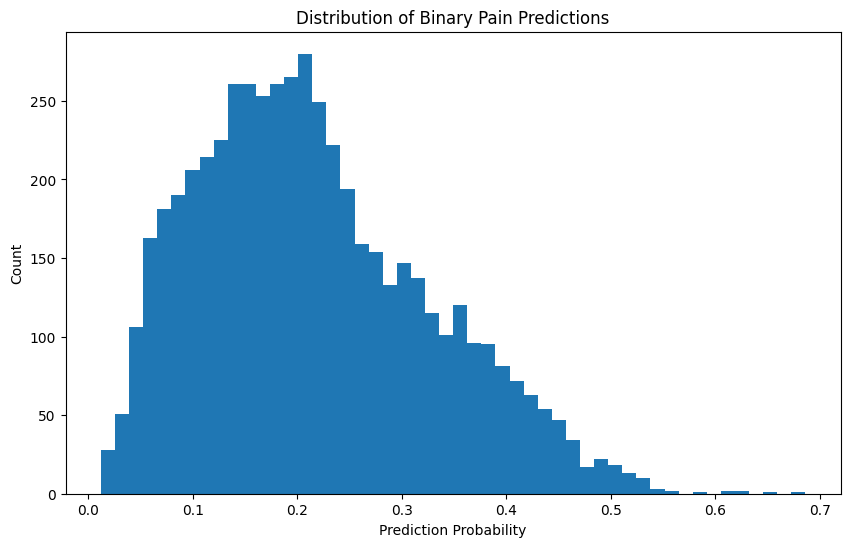

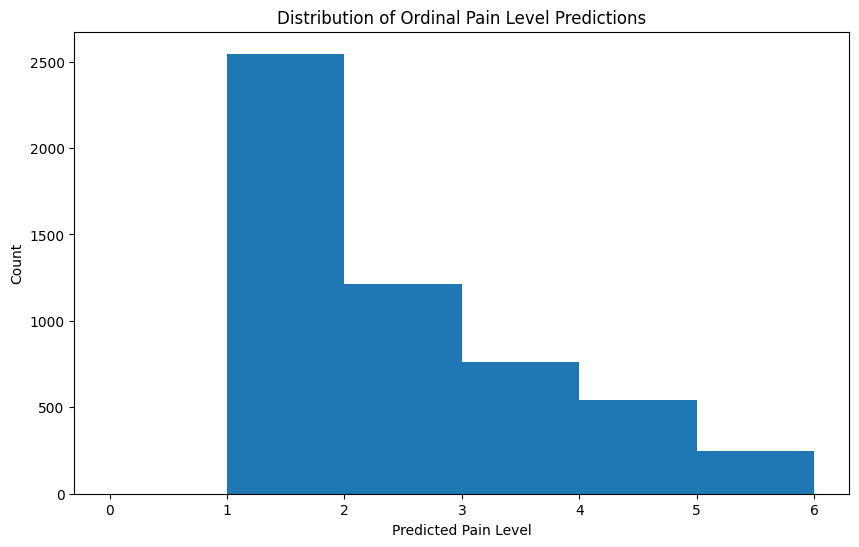


Binary Classification Performance:
Schmerz_Vorfuß_Links: Accuracy = 0.624
Schmerz_Vorfuß_Rechts: Accuracy = 0.603
Schmerz_Mittelfuß_Links: Accuracy = 0.641
Schmerz_Mittelfuß_Rechts: Accuracy = 0.664

Ordinal Prediction Performance:
Schmerz_Stirn: MAE = 0.973
Schmerz_Scheitel: MAE = 1.098
Schmerz_Nackenmuskeln: MAE = 1.868
Schmerz_Nackenwirbelsäule: MAE = 1.922
Schmerz_Brustwirbelsäule: MAE = 1.556
Schmerz_Schulter+Arm_Links: MAE = 1.698
Schmerz_Schulter+Arm_Rechts: MAE = 1.847
Schmerz_Lendenwirbelsäule: MAE = 1.827
Schmerz_Hüfte_Links: MAE = 1.756
Schmerz_Hüfte_Rechts: MAE = 1.807
Schmerz_Po+Oberschenkel_Links: MAE = 1.834
Schmerz_Po+Oberschenkel_Rechts: MAE = 1.854
Schmerz_Knie_Links: MAE = 1.922
Schmerz_Knie_Rechts: MAE = 1.997
Schmerz_Unterschenkel_Links: MAE = 1.417
Schmerz_Unterschenkel_Rechts: MAE = 1.464
Schmerz_Sprunggelenk_Links: MAE = 1.569
Schmerz_Sprunggelenk_Rechts: MAE = 1.498


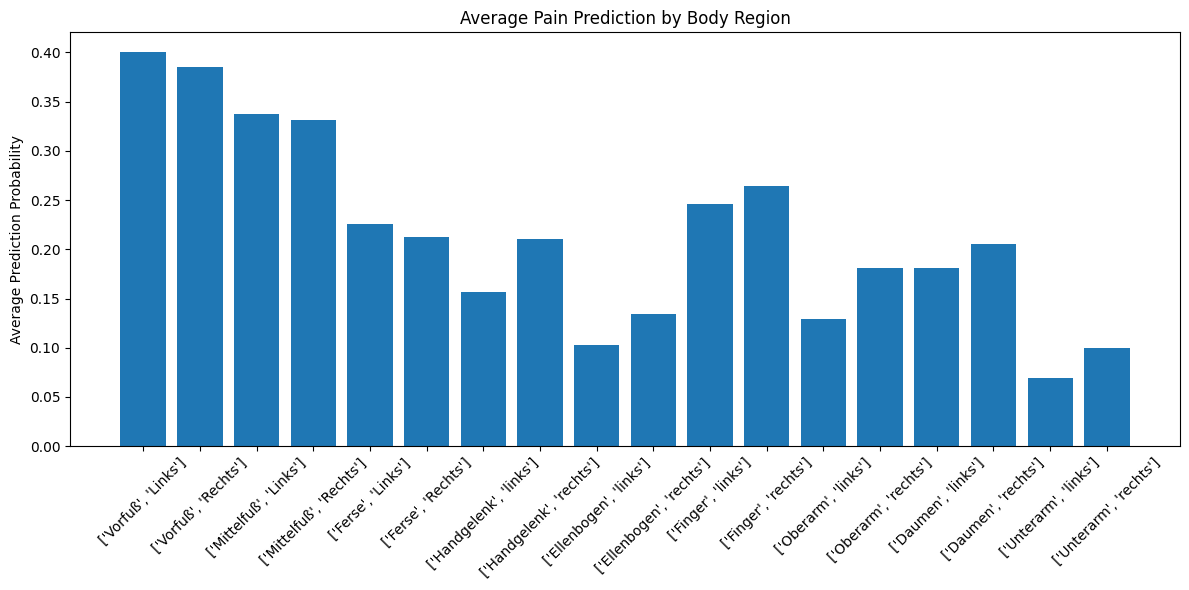

In [21]:
# Visualize binary predictions distribution
plt.figure(figsize=(10, 6))
plt.hist(binary_preds.cpu().numpy().flatten(), bins=50)
plt.title('Distribution of Binary Pain Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.show()

# Visualize ordinal predictions
plt.figure(figsize=(10, 6))
all_ordinal_preds = np.concatenate([pred for pred in ordinal_preds])
plt.hist(all_ordinal_preds, bins=range(7))
plt.title('Distribution of Ordinal Pain Level Predictions')
plt.xlabel('Predicted Pain Level')
plt.ylabel('Count')
plt.show()

# Print performance metrics
print("\nBinary Classification Performance:")
binary_preds_class = (binary_preds.cpu().numpy() > 0.5).astype(int)
for i, col in enumerate(binary_target_cols[:4]):
    accuracy = (binary_preds_class[:, i] == yb_test[:, i]).mean()
    print(f"{col}: Accuracy = {accuracy:.3f}")

print("\nOrdinal Prediction Performance:")
for i, col in enumerate(ordinal_target_cols):
    mae = np.abs(ordinal_preds[i] - yo_test[:, i]).mean()
    print(f"{col}: MAE = {mae:.3f}")

# Visualize predictions by body region
plt.figure(figsize=(12, 6))
avg_pred_by_region = binary_preds.cpu().numpy().mean(axis=0)
plt.bar(range(len(binary_target_cols)), avg_pred_by_region)
plt.xticks(range(len(binary_target_cols)), [col.split('_')[-2:] for col in binary_target_cols], rotation=45)
plt.title('Average Pain Prediction by Body Region')
plt.ylabel('Average Prediction Probability')
plt.tight_layout()
plt.show()